# Circular track runs using von Mises (~ circular Gaussian) place fields

In [12]:
#import networkx as nx
#import pyximport; pyximport.install()
import sys
sys.path.insert(0, './helpers')

import numpy as np
import circstats as circ # for von Mises pdf
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Experimental parameters

In [13]:
NumNeurons = 100;

NeuronParameters = {
"pfminsize" : 25,     # minimum place field width [cm] (std dev)
"pfmaxsize" : 75,    # maximum place field width [cm] (std dev)
"pcminrate" : 5,      # minimum peak firing rate [Hz]
"pcmaxrate" : 25,     # maximum peak firing rate [Hz]
"minbkgrate" : 0.5,   # minimum background firing rate [Hz] (non-place cells)
"maxbkgrate" : 2     # maximum background firing rate [Hz] (non-place cells)
};

WorldParameters = {
"NEnv" : 5,     # number of environments
"alpha" : 0.5,     # probability that a recorded cells is active in env
"TrackLength" : 300           # track circumference in cm
};

# Generate Neurons

In [14]:
Neurons = []; # Neurons will be a list of parameters per neuron
def GenerateNeuron(WorldParameters, NeuronParameters) :
    NEnv = WorldParameters["NEnv"];
    Neuron = { "NEnv" : NEnv,
        "PFCenter": np.random.uniform(0, WorldParameters["TrackLength"], NEnv),
        "PFRate" : np.random.uniform(NeuronParameters["pcminrate"], NeuronParameters["pcmaxrate"], NEnv) * 
              np.random.binomial(1,WorldParameters["alpha"],NEnv),
        "PFWidth" : np.random.uniform(NeuronParameters["pfminsize"], NeuronParameters["pfmaxsize"], NEnv),
        "BackgroundRate" : np.random.uniform(NeuronParameters["minbkgrate"], NeuronParameters["maxbkgrate"], NEnv)}
    return Neuron
for i in range(0,NumNeurons) :
    Neurons.append(GenerateNeuron(WorldParameters,NeuronParameters))
    
Neurons.sort(key=lambda neuron: neuron['PFCenter'][0]) # sort by PF locations in environment 1

In [15]:
Neurons[0]

{'BackgroundRate': array([ 1.50587237,  0.61107941,  1.74729287,  1.81506153,  1.59926288]),
 'NEnv': 5,
 'PFCenter': array([   1.75766433,  165.14516887,  195.033267  ,  115.83610262,
          36.55890707]),
 'PFRate': array([ 0.,  0.,  0.,  0.,  0.]),
 'PFWidth': array([ 30.86546154,  28.08094259,  45.12775995,  74.14566209,  65.22138916])}

In [16]:
# Modify for a circular track. Assume TrackDiameter is the same as TrackLength
WorldParameters["TrackCircumference"] = WorldParameters["TrackLength"]
for n in Neurons :
    n["PFTheta"] = 2 * np.pi * n["PFCenter"] / WorldParameters["TrackCircumference"]; # Angle of PF
    n["PFKappa"] = 2 * np.pi * n["PFWidth"] / WorldParameters["TrackCircumference"];
    n["PFRateScaling"] = n["PFRate"] * np.i0(n["PFKappa"]) * 2 * np.pi / np.exp(n["PFKappa"])
Neurons[0]

{'BackgroundRate': array([ 1.50587237,  0.61107941,  1.74729287,  1.81506153,  1.59926288]),
 'NEnv': 5,
 'PFCenter': array([   1.75766433,  165.14516887,  195.033267  ,  115.83610262,
          36.55890707]),
 'PFKappa': array([ 0.64644471,  0.58812589,  0.94515359,  1.55290312,  1.36599358]),
 'PFRate': array([ 0.,  0.,  0.,  0.,  0.]),
 'PFRateScaling': array([ 0.,  0.,  0.,  0.,  0.]),
 'PFTheta': array([ 0.03681244,  3.45879233,  4.08476719,  2.42606566,  0.76568796]),
 'PFWidth': array([ 30.86546154,  28.08094259,  45.12775995,  74.14566209,  65.22138916])}

In [17]:
# Von Mises Place Field Rate Function
def PlaceFieldRate(phi, Env, NeuronParams) : # phi is current track position in radians
    y = circ.vmpdf(phi, NeuronParams["PFTheta"][Env], NeuronParams["PFKappa"][Env])
    return y * NeuronParams["PFRateScaling"][Env] + NeuronParams["BackgroundRate"][Env]

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


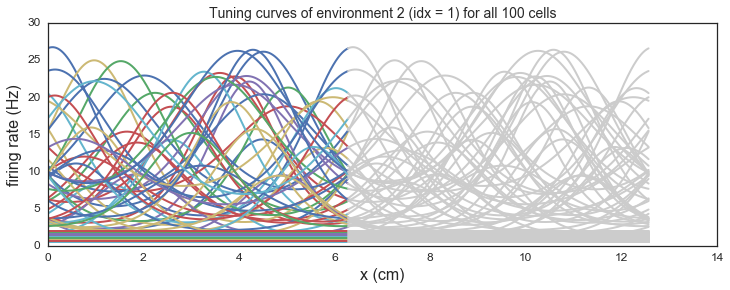

In [18]:

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

f, (ax1) = plt.subplots(1,1)

Phi = np.linspace(0,2*np.pi,1000);
ee = 1; # select environment
for n in Neurons :
    ax1.plot(Phi,PlaceFieldRate(Phi,ee,n))
    ax1.plot(Phi + 2*np.pi, PlaceFieldRate(Phi,ee,n), color=[0.8,0.8,0.8])

ax1.set_xlabel('x (cm)')
ax1.set_ylabel('firing rate (Hz)')
ax1.set_title('Tuning curves of environment {0} (idx = {1}) for all {2} cells'.format(ee+1,ee,NumNeurons),fontsize=14)



# Generate Neural Activity

In [19]:
# Synthesize neural activity using rat running at constant (circular) rate
RatLinearSpeed = 20; # 20 cm/s
RatRadialSpeed = 2 * np.pi * RatLinearSpeed / WorldParameters["TrackCircumference"]

TrajLength = 10; # seconds; corresponds to 30% of the track. 
    
# We'll generate several trajectories for each environment
NumTrajectories = 1000;
TrajStartPos = np.random.uniform(0, 2*np.pi, (NumTrajectories, WorldParameters["NEnv"]))

In [20]:
from GenerateInhomogeneousPlaceCellSpikes import GenerateSpikes
import time

# Initialize SpikeRaster as a list of lists of lists, where the first (outer) dimension
#  is environment, the next dimension is trajectory, and the final dimension is neuron.
#  Then, for each neuron, there is a np.ndarray which contains the spike times for that
#  neuron on that trajectory of that environment.
SpikeRasters = [[[[] for _ in range(len(Neurons))] for _ in range(NumTrajectories)] for _ in range(WorldParameters["NEnv"])]
t0 = time.time();
for ee in range(WorldParameters["NEnv"]) :
    for k in range(NumTrajectories) :
        for (i,n) in enumerate(Neurons) :
            posFun = lambda t : np.mod(RatRadialSpeed * t + TrajStartPos[k][ee], 2 * np.pi)
            SpikeRasters[ee][k][i] = GenerateSpikes(lambda x,t : PlaceFieldRate(x, ee, n), n["PFRate"][ee], 
                                                    posFun, TrajLength);

t1 = time.time();
print(t1-t0)

15.734946966171265


In [21]:
type(SpikeRasters[0][k][0])

numpy.ndarray

In [22]:
import pickle
with open("vonMisesData_100neurons_extralong.p", "wb") as output_file:
    pickle.dump(
        [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters],
        output_file)